# Dasymetric Disaggregation using Google Earth Engine
[**Rhorom Priyatikanto**](mailto:rp1y21@soton.ac.uk)<br>
WorldPop - University of Southampton

## Pre-requisites
1. Basic skill in _Python_ programming language
2. Basic knowledge on the Google Earth Engine
2. Basic understanding in GIS concepts, including raster and vector data processing and analysis

## Table of contents
1. [Main courses](#main-courses)
2. [Introduction](#introduction)
3. [Input data](#input-data)
4. [Simple disaggregation](#simple-disaggregation)
5. [Checking the results](#checking-the-results)
6. [Exporting the results](#exporting-the-results)

## Main courses
In this tutorial, we will create a gridded population dataset using a simple dasymetric mapping that relies on a single ancillary data representing population distribution over a spatial extent.

## Introduction
Gridded population data is created by taking census data, which is typically collected at the administrative unit level, and distributing that population across a grid of raster cells. Census, that becomes the primary source of population data, provides counts of people within specific administrative boundaries (e.g., counties, districts). Using a certain method, the population within each administrative unit is distributed across the grid cells that intersect with that unit. This method is known as top-down approach.

There are two major methods to distribute or disaggregate population into grid cells:
- **Areal Weighting**: This common method assumes a uniform population distribution within each administrative unit and allocates population to grid cells based on the proportion of the unit's area covered by each cell.

- **Dasymetric Mapping**: This method uses ancillary data (e.g., land cover, building density) to refine the population distribution within administrative units, resulting in a more realistic representation.

Dasymetric mapping becomes a method to create accurate and reliable gridded population datasets like [WorldPop Global Project Population Data](https://developers.google.com/earth-engine/datasets/catalog/WorldPop_GP_100m_pop#image-properties) and [LandScan Population Data](https://developers.google.com/earth-engine/datasets/catalog/projects_sat-io_open-datasets_ORNL_LANDSCAN_GLOBAL). This method leverages additional information, called ancillary data, to more accurately reallocate the original data within these areas. The goal is to achieve a distribution that better reflects the true spatial pattern of the phenomenon being mapped. Ancillary data is the crucial ingredient that distinguishes dasymetric mapping. It consists of spatial datasets that correlate with the distribution of the source data. Common examples include:
- Land cover/land use data: Identifying areas unsuitable for human habitation (e.g., water bodies, forests) or with varying population densities (e.g., urban vs. rural).
- Building footprints/density data: Indicating areas with higher potential for population concentration.
- Nighttime lights data: Suggesting areas of human activity and potential population presence.

Based on the available ancillary data, the population count at administrative unit level is then proportionally redistributed within this zones.

## Input data
In this tutorial, we aim for disaggregating population of Skaane County in Sweden using two ancillary data:
- [VIIRS Nighttime Composite](https://developers.google.com/earth-engine/datasets/catalog/NOAA_VIIRS_DNB_ANNUAL_V21) representing the amount of lights emitted from the Earth's surface as measured by the Visible Infrared Imaging Radiometer Suite onboard Suomi NPP satellite. The dataset contains several bands, including the average nighttime radiance to be used for dasymetric disaggregation. It has a spatial resolution of around 500 m.

- [GHSL Global Building Volume](https://developers.google.com/earth-engine/datasets/catalog/JRC_GHSL_P2023A_GHS_BUILT_V) depicts the global distribution of building volume, expressed in cubic metres per 100 m grid cell. Following the characteristics of the building, i.e., residential and non-residential, we can estimate the building volume allocated for residential use, which is relevant for population disaggregation.

We use [WorldPop Global Project Population Data](https://developers.google.com/earth-engine/datasets/catalog/WorldPop_GP_100m_pop#image-properties) as the basis. The total population of Blekinge County (admin-1) and the population counts at every subcounty (admin-2) are obtained through zonal statistics using appropriate administrative boundaries. The [Global Administrative Unit Layer](https://developers.google.com/earth-engine/datasets/catalog/FAO_GAUL_2015_level2) contains administrative boundaries we can use to define the region of interest for this tutorial.

In [3]:
import ee
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from IPython.display import display, Image, HTML
from shapely.geometry import Polygon, MultiPolygon
ee.Initialize()

In [4]:
geometry = ee.Geometry.Point(13.0,55.6) #a point near Malmoe
adm1 = (ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level1")
  .filterBounds(geometry)
  .select(['ADM1_NAME', 'ADM1_CODE']))
  
adm2 = (ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level2")
  .filterBounds(adm1)
  .select(['ADM1_NAME', 'ADM1_CODE', 'ADM2_NAME', 'ADM2_CODE']))

![](fig/blekinge.PNG)

Then, we can import WorldPop data and the ancillary data layers.

In [5]:
wpgp = (ee.ImageCollection("WorldPop/GP/100m/pop")
    .filterDate('2020-01-01','2020-12-31')
    .filterBounds(adm1).mosaic().clip(adm1).rename('pop'))

viirs = (ee.ImageCollection("NOAA/VIIRS/DNB/ANNUAL_V21")
    .filterDate('2020-01-01','2020-12-31')
    .filterBounds(adm1).first().clip(adm1).select('average'))
viirs = viirs.where(viirs.lt(0.25), ee.Image(0))

ghsv = (ee.Image('JRC/GHSL/P2023A/GHS_BUILT_V/2020')
    .clip(adm1))
ghsl = (ghsv.select('built_volume_total')
    .subtract(ghsv.select('built_volume_nres')))

The annual composite of VIIRS data contains the average radiance in nanoWatts/sr/cm2. Typically the cell values range from 0 to 10. To obtain more realistic result where the people resides in settlement area in cities, towns, and the surroundings, we apply minimum threshold to the VIIRS data. Cell values below 0.25 nanoWatts/sr/cm2 are set to zero.

For the Building Volume dataset, we subtract the total volume with the volume of non-residential buildings. Thus, cell values represent the volume of buildings used as residence.

With the required images in hand, we are able to aggregate the data at admin-1 level. The resulting table will be used for dasymetric disaggregation. Just before aggregation, the images are stacked into an image with three bands, i.e., `pop`, `viirs`, and `ghsl`. 

In [6]:
wpgp = (wpgp.rename('pop')
  .addBands(viirs.rename('viirs'))
  .addBands(ghsl.rename('ghsl')))
  
pop1 = wpgp.reduceRegions(
  collection = adm1,
  scale = 100,
  reducer = ee.Reducer.sum()
)

Printing the table gives the following information
```javascript
FeatureCollection (1 element, 3 columns)
    type: FeatureCollection
    columns: Object (3 properties)
    features: List (1 element)
        0: Feature 0000000000000000081f (MultiPolygon, 5 properties)
            type: Feature
            id: 0000000000000000081f
            geometry: MultiPolygon, 546 vertices
            properties: Object (5 properties)
            ADM1_CODE: 2798
            ADM1_NAME: Skaane Laen
            ghsl: 1012538246.200001
            pop: 1194366.2647774743
            viirs: 4201327.650036133
```

## Simple disaggregation
Suppose the total population in the selected admin-1 unit is $pop_j$ while the ancillary data value at each grid cell is $x$. Using proportional disaggregation rule, the estimated population at grid cell is
$$\hat{pop}_i=\frac{pop_j}{\sum x_i} \times x_i=f_j \times x_i,$$
where $\sum{x_i}$ is the total value of $x$ at specified unit. This total acts as the normalising factor which transforms the ancillary data into a probability of getting people in a particular grid cell. 

As the sum of $x_i$ for `viirs` and `ghsl` have been obtained through prior zonal statistics, we can compute $f_j$ using the following commands:

In [7]:
def normalise(feat):
    pop = feat.getNumber('pop')
    f1 = pop.divide(feat.getNumber('viirs'))
    f2 = pop.divide(feat.getNumber('ghsl'))
    return feat.set('f1', f1, 'f2', f2)
pop1 = pop1.map(normalise)

Multiplication of $f_j$ and the ancillary data $x$ yields the population estimate. However, we need to convert $f_j$ stored in `FeatureCollection` `pop1` into an `Image` so that multiplication can be done at grid level. This so called rasterisation process can be performed using `reduceToImage()` method attached to `FeatureCollection` class.

In [9]:
f1 = pop1.reduceToImage(
  properties = ['f1'],
  reducer = ee.Reducer.sum()
)

f2 = pop1.reduceToImage(
  properties = ['f2'],
  reducer = ee.Reducer.sum()
)

Afterward, grid level (pixel-wise) multiplication can be performed and the estimated population using two ancillary data can be stacked for further assessments.

In [14]:
e1 = wpgp.select('viirs').multiply(f1)
e2 = wpgp.select('ghsl').multiply(f2)
estimate = (wpgp.select('pop')
  .addBands(e1.rename('est_viirs'))
  .addBands(e2.rename('est_ghsl')))

## Checking the results
Let's visualise the dasymetric results on a map and compare them to the basis gridded population data.

In [42]:
nsteps = 7
surrounding = geometry.buffer(10000)
palette = [clr.rgb2hex(plt.get_cmap('inferno_r', nsteps)(a/nsteps)) for a in range(nsteps)]
vis = {'min':0, 'max':50, 'palette':palette, 'region':surrounding, 'dimensions':256};

url_wpgp = wpgp.select('pop').getThumbUrl(vis)
url_viirs = estimate.select('est_viirs').getThumbUrl(vis)
url_ghsl = estimate.select('est_ghsl').getThumbUrl(vis)

In [43]:
fmt = "<img style='width:256px; height:256px; margin:2px; float:left; border:1px solid black;' src='{0}' />"
img = ''.join( [fmt.format(s) for s in [url_wpgp,url_viirs,url_ghsl]])
display(HTML(img))

Visually, the estimate from VIIRS data is fuzzier compared to the WorldPop data while the one from GHSL is more granular. As expected, VIIRS with a 500-m resolution yields a coarser gridded population estimate. In terms of resolution, GHSL data has the same granularity compared to the WorldPop data so that the resolutions of the ancillary data can't explain the difference. Variation in building volume is directly propagated to the population estimate. Meanwhile, WorldPop data is produced using Random Forest algorithm that incorporates multiple covariates to get the probability layer for dasymetric redistribution. Combination of covariates with different resolutions creates a layer that is significantly fuzzier that its grid size.

Further assessment can be performed by aggregating the population estimate to admin-2 level and compare the values with the ones from WorldPop. The table can be directly downloaded by printing the `pop2` as a dictionary.

In [20]:
pop2 = estimate.reduceRegions(
  collection = adm2,
  scale = 100,
  reducer = ee.Reducer.sum()
)

pop2 = pop2.map(lambda feat: feat.set('ref', feat.getNumber('pop')))
pop2_local = pop2.getInfo()

In [24]:
def get_geodataframe(fc, keep_geom=True):
    df = pd.DataFrame()
    geom = []
    for f in fc['features']:
        d = pd.DataFrame(f['properties'], index=[0])
        df = pd.concat([df, d], ignore_index=False)
        
        if f['geometry']['type'] == 'Polygon':
            geom.append(Polygon(f['geometry']['coordinates'][0]))
        else:
            geom.append(MultiPolygon(f['geometry']['coordinates']))
            
    df = gpd.GeoDataFrame(data=df, geometry=geom).reset_index(drop=True)
    return df

gdf = get_geodataframe(pop2_local)

gdf.drop(columns='geometry').head(2)

,ADM1_CODE,ADM1_NAME,ADM2_CODE,ADM2_NAME,est_ghsl,est_viirs,pop,ref
0,2786,Blekinge Laen,25998,Olofstroem,10.219836,18.033552,2.299145,2.299145
1,2786,Blekinge Laen,26000,Soelvesborg,0.400404,10.152062,4.726520,4.726520


To see how the estimated population counts deviate from the WorldPop data, we can calculate the deviations at admin-2 level and visualise the deviations on a map using a diverging color scale.

Additionally, the scores are:

| Score | `est_viirs` | `est_ghsl` |
| ----- | ----------- | ---------- |
| Bias	| -2.16 | 0.08 |
| RMSE	| 20017 | 7483 |
| MAPE	| 0.80  | 0.36 |
| R2	| 0.91  | 0.98 |

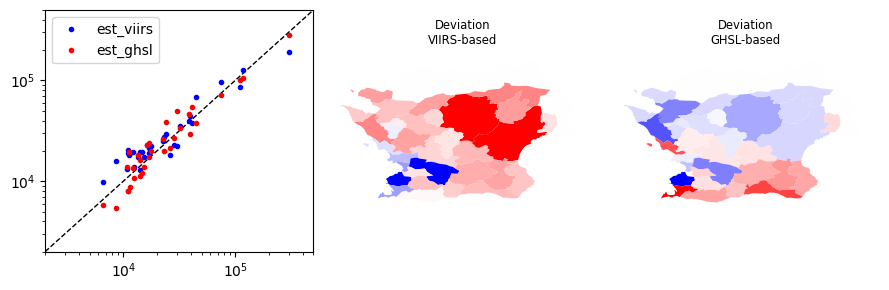

In [40]:
gdf['dev_viirs'] = gdf['est_viirs'] - gdf['pop']
gdf['dev_ghsl'] = gdf['est_ghsl'] - gdf['pop']

fig,ax = plt.subplots(1, 3, figsize=(9,3), dpi=100)
ax[0].plot([2e3, 5e5], [2e3, 5e5], '--k', lw=1)
ax[0].plot(gdf['pop'], gdf['est_viirs'], '.b', label='est_viirs')
ax[0].plot(gdf['pop'], gdf['est_ghsl'], '.r', label='est_ghsl')
ax[0].legend()

d = {'VIIRS-based':'dev_viirs', 'GHSL-based':'dev_ghsl'}

for a,b in enumerate(d):
    gdf.plot(column=d[b], cmap='bwr', vmin=-2e4, vmax=2e4, ax=ax[a+1])
    ax[a+1].set_axis_off()
    ax[a+1].set_aspect('equal')
    ax[a+1].set_title('Deviation\n' + b, fontsize='small')

ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlim(2e3, 5e5)
ax[0].set_ylim(2e3, 5e5)
    
plt.tight_layout()
plt.show()

## Exporting the results
Lastly, the raster products of our simple dasymetric disaggregation of population in Skaane region can be exported to Google Drive. The following commands export the `est_viirs` band from the `estimate` image as `GeoTIFF` with 100-m resolution. A standard `EPSG:4326` (WGS84) projection is applied to the image.

```python
task = ee.batch.Export.image.toDrive(
  image = estimate.select('est_viirs'),
  description = 'dasymetric_viirs',
  folder = 'gee',
  region = adm1,
  fileFormat = 'GeoTIFF',
  crs = 'EPSG:4326',
  scale = 100
)
task.start()
```